## 自建数据生成器
自建数据生成器仅支持而分类，建议使用API数据生成器

In [1]:
import glob

# real_list  = glob.glob(r".\images\1/*.png")
# glitch_list = glob.glob(r".\images\0/*png")

real_list  = glob.glob(r".\hotdog\train\hotdog/*.png")
glitch_list = glob.glob(r".\hotdog\train\not-hotdog/*png")

list_img = real_list+glitch_list

print(len(real_list), len(glitch_list))

1000 1000


In [2]:
import cv2
import numpy as np
import pprint as pp

def get_batch(img_list, label_list, batch_size=8, show=False):
    # 在方法中需要用while写成死循环，因为每个step不会重新调用方法
    while True:
        index = np.random.choice(range(len(img_list)), batch_size)
        batch_list = [img_list[i] for i in index]
        batch_row = [cv2.imread(img) for img in batch_list]
        batch_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in batch_row]
        batch_matrix = [cv2.resize(i,(224, 224),interpolation=cv2.INTER_CUBIC) for i in batch_gray]
        batch_label = [label_list[i] for i in index]
        if show:
            pp.pprint(list(zip(batch_list, batch_label)))
        batch_matrix = np.concatenate(np.expand_dims(batch_matrix, axis=0), axis=0).astype(float)
        batch_label = np.array(batch_label)
        # batch_matrix = np.expand_dims(batch_matrix, -1)
        batch_matrix = (batch_matrix).astype(int)/255.
        yield batch_matrix, batch_label# , batch_list


list_lab = np.zeros([len(list_img), 2], dtype=int)
list_lab[:len(real_list), 0] = 1  # real: [1, 0]
list_lab[len(real_list):, 1] = 1  # fake: [0, 1]
b = next(get_batch(list_img, list_lab, show=True))

[('.\\hotdog\\train\\hotdog\\757.png', array([1, 0])),
 ('.\\hotdog\\train\\hotdog\\924.png', array([1, 0])),
 ('.\\hotdog\\train\\hotdog\\271.png', array([1, 0])),
 ('.\\hotdog\\train\\hotdog\\937.png', array([1, 0])),
 ('.\\hotdog\\train\\not-hotdog\\435.png', array([0, 1])),
 ('.\\hotdog\\train\\hotdog\\589.png', array([1, 0])),
 ('.\\hotdog\\train\\hotdog\\203.png', array([1, 0])),
 ('.\\hotdog\\train\\not-hotdog\\818.png', array([0, 1]))]


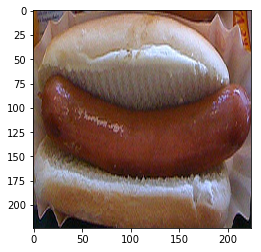

In [3]:
import matplotlib.pyplot as plt
num = np.random.randint(0, len(b))
img = (b[0][num]*255).astype(np.uint8) 
plt.imshow(img)
plt.show()
# print(b[2][num])
# pp.pprint(list(zip(b[1][:], b[2][:])))

## API数据生成器
官方的数据读取器，路径指定到图片父级目录，其下有各个class的子目录即可

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# train_datagen=ImageDataGenerator(rescale=1./255)
# train_flow=train_pic_gen.flow_from_directory(r'./hotdog\train',target_size=(128, 128),batch_size=32,class_mode='categorical')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_flow = train_datagen.flow_from_directory(
        r'./hotdog\train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.


## 网络定义

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten,Dropout 
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import InceptionV3


model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())# this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

# model = Sequential()
# model.add(InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3)))
# # build a classifier model to put on top of the convolutional model
# top_model = Sequential()
# top_model.add(Flatten(input_shape=model.output_shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(2, activation='sigmoid'))
 
# # note that it is necessary to start with a fully-trained
# # classifier, including the top classifier,
# # in order to successfully do fine-tuning
# # top_model.load_weights(top_model_weights_path)
# # add the model on top of the convolutional base
# model.add(top_model)
# for layer in model.layers[:25]:
#     layer.trainable = False

model.summary()

C:\software\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

C:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(224, 224,...)`
  if __name__ == '__main__':
C:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  del sys.path[0]
C:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


## 训练

In [ ]:
from keras import losses
import keras.backend as K
from keras import optimizers
from keras.callbacks import TensorBoard

samples_per_epoch = len(list_img)
batch_size = 32

# K.set_value(sgd.lr, 0.5 * K.get_value(sgd.lr))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit_generator(# train_flow,  
                    get_batch(list_img, list_lab),
                    steps_per_epoch=len(real_list)+len(glitch_list)//batch_size, # samples_per_epoch//batch_size, 
                    epochs=5,
                    shuffle=True,
                    callbacks=[TensorBoard(log_dir='./tmp/log', write_graph=True)])
# model.fit(img, label, batch_size=8, epochs=10)
model.save('model.h5')

Epoch 1/5
 804/1031 [======================>.......] - ETA: 12s - loss: 0.6656 - acc: 0.6233

# 测试
须将下面两个路径替换为测试图片的路径：
```
test_real_list  = glob.glob("./0/*.jpg")
test_glitch_list = glob.glob("./1/*jpg")
```

In [ ]:
import matplotlib.pyplot as plt

test_real_list  = glob.glob("./0/*.jpg")
test_glitch_list = glob.glob("./1/*jpg")
test_list_img = test_real_list + test_glitch_list

img_test = [cv2.imread(i) for i in test_list_img]
img_test = [cv2.resize(i,(300, 300),interpolation=cv2.INTER_CUBIC)
            for i in img_test]
img_test = np.concatenate(np.expand_dims(img_test, axis=0), axis=0)/255

label_test = np.zeros([len(img_test), 2], dtype=int)
label_test[:len(test_real_list), 0] = 1
label_test[len(test_real_list):, 1] = 1
pp.pprint(list(zip(test_list_img, label_test)))

In [9]:
import keras.models as KM

model = KM.load_model('model.h5')
result = model.evaluate(img_test, label_test)
pp.pprint(list(zip(model.metrics_names, result)))

42/42 [==============================] - 1s 13ms/step
[('loss', 0.009871753686595531), ('acc', 1.0)]
